# HM-OT synth example

## imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scanpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00


In [4]:
!pip install moscot -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.1 MB/s eta 0:00:00


In [5]:
!pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 61.9 MB/s eta 0:00:00


In [6]:
!pip install diffrax -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 7.6 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import sys
import importlib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
filehandle_hmot = 'drive/Othercomputers/numac/GitHub/HM-OT/'
filehandle_save = 'drive/MyDrive/DX/_data/melanocyte/save/'
filehandle_save_factors = 'drive/MyDrive/DX/_data/melanocyte/save_factors/'
filehandle_mel = 'drive/MyDrive/DX/_data/melanocyte/cleaned_common_pca_sc/'

sys.path.insert(0, filehandle_hmot)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_mel)

import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.clustering as clustering
import src.utils.util_LR as util_LR
import src.utils.util_zf as util_zf
from src.utils.util_LR import convert_adata
import src.plotting as plotting

import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

## reload

In [9]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(HiddenMarkovOT)
importlib.reload(plotting)

<module 'src.plotting' from '/content/drive/Othercomputers/numac/GitHub/HM-OT/src/plotting.py'>

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float32

On device: cuda


## make synthetic data: >2 timepoints

In [116]:
import numpy as np
import torch

device, dtype = "cpu", torch.float32

n_per_cluster_og=(
    [333, 333, 333],                      # 3 clusters
    [167, 166, 167, 167, 166, 166],       # 6 clusters
    [167, 166, 167, 167, 166, 166],       # 6 clusters
)

proportions = [
    np.array([1000, 1000, 1000]),                                  # t = 0
    np.array([500, 500, 500, 500, 500, 500]),                   # t = 1
    np.array([500, 500, 500, 500, 500, 500]),                   # t = 2
]
proportions_tens = [torch.from_numpy(p).type(dtype).to(device) / 3000.0
                    for p in proportions]

# ────────────────────────────────────────────────────────────────────────────────
def generate_branching_blobs(
    n_per_cluster=(
        [1000, 1000, 1000],                      # 3 clusters
        [500, 500, 500, 500, 500, 500],       # 6 clusters
        [500, 500, 500, 500, 500, 500],       # 6 clusters
    ),
    std=0.6,
    random_seed=0,
):
    rng = np.random.default_rng(random_seed)

    # centres[t][cid]  ──>  (x, y)
    centres = {
        0: {0: np.r_[ -0.11,  0.11],
            1: np.r_[ -0.11, -0.22],
            2: np.r_[  0.11,  0.00]},

        1: {3: np.r_[ -1.0,  1.5],     # children of 0
            4: np.r_[ -1.5,  1.0],     # "
            5: np.r_[ -0.5, -2.0],     # children of 1
            6: np.r_[ -1.0, -1.5],     # "
            7: np.r_[  1.5,  0.5],     # children of 2
            8: np.r_[  1.5, -0.5]},    # "

        2: { 9: np.r_[ -1.5,  2.0],    # child of 3
            10: np.r_[ -2.5,  1.0],    # child of 4
            11: np.r_[ -0.5, -2.5],    # child of 5
            12: np.r_[ -2.0, -1.5],    # child of 6
            13: np.r_[  2.0,  1.0],    # child of 7
            14: np.r_[  2.0, -1.0]},   # child of 8
    }

    # which global IDs appear — and in which order — at each time-point
    cluster_ids = {
        0: [0, 1, 2],                       # founders
        1: [3, 4, 5, 6, 7, 8],              # first split
        2: [9, 10, 11, 12, 13, 14],         # second split
    }

    # lineage  (parent → children)   keys are “time-t” *parents*
    lineage = {
        0: {0: [3, 4],                      # t = 0  →  t = 1
            1: [5, 6],
            2: [7, 8]},

        1: {3:  [9],                        # t = 1  →  t = 2
            4: [10],
            5: [11],
            6: [12],
            7: [13],
            8: [14]},
    }

    X_parts, t_parts, c_parts = [], [], []

    for t, counts in enumerate(n_per_cluster):
        ids_t = cluster_ids[t]
        assert len(ids_t) == len(counts), "counts and ids length mismatch"

        # build each blob using the **true** cluster ID
        blobs_t = []
        clabels_t = []
        for n_pts, cid in zip(counts, ids_t):
            blob = rng.normal(loc=centres[t][cid], scale=std, size=(n_pts, 2))
            blobs_t.append(blob)
            clabels_t.append(np.full(n_pts, cid, dtype=int))

        X_parts.append(np.vstack(blobs_t))
        t_parts.append(np.full(sum(counts), t, dtype=int))
        c_parts.append(np.concatenate(clabels_t))

    X              = np.vstack(X_parts)
    time_labels    = np.concatenate(t_parts)
    cluster_labels = np.concatenate(c_parts)
    return X, time_labels, cluster_labels, lineage

In [117]:
### set params

FIGSIZE = 16
random_state = 42
n_timepoints = 3
std=0.3

In [118]:
X, time_labels, cluster_labels, lineage = generate_branching_blobs(n_per_cluster=n_per_cluster_og,
                                                                   std=std,
                                                                   random_seed=random_state)

In [119]:
def generate_Q_matrices_from_clusters(X,
                                      time_labels,
                                      cluster_labels,
                                      lineage,
                                      device="cpu",
                                      dtype=torch.float32):
    unique_times = np.unique(time_labels)
    n_timepoints = len(unique_times)

    cluster_ids_per_time = {}
    for t in unique_times:
        mask_t = (time_labels == t)
        clusters_at_t = np.unique(cluster_labels[mask_t])
        cluster_ids_per_time[t] = sorted(clusters_at_t)

    Q_matrices = []

    for t in unique_times:
        mask_t = (time_labels == t)
        cells_at_t = np.sum(mask_t)
        clusters_at_t = cluster_labels[mask_t]
        unique_clusters_t = cluster_ids_per_time[t]
        n_clusters_t = len(unique_clusters_t)

        cluster_to_col = {cid: i for i, cid in enumerate(unique_clusters_t)}

        Q_t = np.zeros((cells_at_t, n_clusters_t))

        for i, cluster_id in enumerate(clusters_at_t):
            col_idx = cluster_to_col[cluster_id]
            Q_t[i, col_idx] = 1.0

        # Convert to tensor
        # Q_tensor = torch.from_numpy(Q_t).type(dtype).to(device)
        Q_matrices.append(Q_t)

        print(f"Time {t}: {cells_at_t} cells, {n_clusters_t} clusters")
        print(f"  Cluster IDs: {unique_clusters_t}")
        print(f"  Q matrix shape: {Q_t.shape}")

    return Q_matrices, cluster_ids_per_time

In [120]:
Qs_gt, clusters_gt = generate_Q_matrices_from_clusters(X,
                                                       time_labels,
                                                       cluster_labels,
                                                       lineage)

Time 0: 999 cells, 3 clusters
  Cluster IDs: [np.int64(0), np.int64(1), np.int64(2)]
  Q matrix shape: (999, 3)
Time 1: 999 cells, 6 clusters
  Cluster IDs: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
  Q matrix shape: (999, 6)
Time 2: 999 cells, 6 clusters
  Cluster IDs: [np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]
  Q matrix shape: (999, 6)


In [121]:
df = pd.DataFrame({
    "x": X[:, 0],
    "y": X[:, 1],
    "timepoint": time_labels
})

palette = sns.color_palette("husl", n_colors=df["timepoint"].nunique())

fig, ax = plt.subplots(figsize=(FIGSIZE, FIGSIZE))
sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="timepoint",
    palette=palette,
    s=60,
    linewidth=0.3, edgecolor="k",
    ax=ax
)

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend(title="timepoint", bbox_to_anchor=(1.02, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [122]:
X1 = X[time_labels == 0]
X2 = X[time_labels == 1]
X3 = X[time_labels == 2]

kmeans1 = kmeans = KMeans(n_clusters=3,
                          random_state=random_state)
kmeans2 = kmeans = KMeans(n_clusters=6,
                          random_state=random_state)
kmeans3 = kmeans = KMeans(n_clusters=6,
                          random_state=random_state)

klabels1_ = kmeans1.fit_predict(X1)
klabels2_ = kmeans2.fit_predict(X2)
klabels3_ = kmeans3.fit_predict(X3)

klabels1 = klabels1_
klabels2 = klabels2_ + len(set(klabels1))
klabels3 = klabels3_ + len(set(klabels1)) + len(set(klabels2))

Q1_ann = np.eye(len(set(klabels1_)))[klabels1_]
Q2_ann = np.eye(len(set(klabels2_)))[klabels2_]
Q3_ann = np.eye(len(set(klabels3_)))[klabels3_]
Qs_ann = [Q1_ann, Q2_ann, Q3_ann]

Ss = [X1, X2, X3]
cell_type_labels = np.concatenate([klabels1, klabels2, klabels3])

Ts = [None, None, None]
plotting.plot_clusters_from_QT(Ss, Qs_ann, Ts, dotsize=500)

Output hidden; open in https://colab.research.google.com to view.

In [123]:
plotting.plot_all_sc_clusters(spatial_list=Ss,
                              clustering_list=[klabels1, klabels2, klabels3],
                              dotsize=100)

Output hidden; open in https://colab.research.google.com to view.

In [124]:
C_factors_sequence = []

for timepoint in range(2):
    tp1 = X[time_labels == timepoint]
    tp2 = X[time_labels == timepoint+1]
    _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
    _X2 = torch.from_numpy(tp2).type(torch.DoubleTensor).to(device)
    C12 = torch.cdist(_X1, _X2).to(device)
    C12 = C12.to(dtype)
    I = torch.eye(C12.shape[1]).to(dtype).to(device)
    C_factors_sequence.append(( C12, I ))

In [125]:
A_factors_sequence = []

for timepoint in range(n_timepoints):
    tp1 = X[time_labels == timepoint]
    _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
    A1 = torch.cdist(_X1, _X1).to(device)
    A1 = A1.to(dtype)
    I = torch.eye(A1.shape[1]).to(dtype).to(device)
    A_factors_sequence.append(( A1, I ))

In [126]:
proportions_tens

[tensor([0.3333, 0.3333, 0.3333]),
 tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]),
 tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])]

In [127]:
rank_list = [(3,6), (6,6)]
iter = 100
gamma = 120.0
alpha = 0.0
tau_in = 1e5

hmot = HiddenMarkovOT.HM_OT(rank_list = rank_list,
                            max_iter = iter,
                            min_iter = iter,
                            device=device,
                            alpha = alpha,
                            gamma = gamma,
                            dtype = dtype,
                            printCost = False,
                            returnFull = False,
                            initialization = 'Full',
                            tau_in = tau_in,
                            proportions=proportions_tens,
                            )

A_factors_sequence = [None] * (n_timepoints)
hmot.gamma_smoothing(C_factors_sequence,
                    A_factors_sequence)

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Ranks: r1 3, r2 6, r3 6
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75


In [128]:
Qs = hmot.Q_gammas
Ts = hmot.T_gammas

Qs_np = [Q.cpu().detach().numpy() for Q in Qs]
Ts_np = [T.cpu().detach().numpy() for T in Ts]

In [129]:
Qs[-1].sum(axis=0)

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [130]:
Qs = hmot.Q_gammas
Ts = hmot.T_gammas

Qs_np = [Q.cpu().detach().numpy() for Q in Qs]
Ts_np = [T.cpu().detach().numpy() for T in Ts]

plotting.plot_clusters_from_QT(Ss, Qs_np, Ts_np, dotsize=500, clustering_type='ml')

Output hidden; open in https://colab.research.google.com to view.

In [131]:
hmot_labels1_ = np.argmax(Qs_np[0], axis=1)
hmot_labels2_ = np.argmax(Qs_np[1], axis=1)
hmot_labels3_ = np.argmax(Qs_np[2], axis=1)

hmot_labels1 = hmot_labels1_
hmot_labels2 = hmot_labels2_ + len(set(hmot_labels1))
hmot_labels3 = hmot_labels3_ + len(set(hmot_labels1)) + len(set(hmot_labels2))

hmot_clustering_list = [hmot_labels1, hmot_labels2, hmot_labels3]

In [132]:
plotting.plot_all_sc_clusters(spatial_list=Ss,
                              clustering_list=hmot_clustering_list,
                              dotsize=100)

Output hidden; open in https://colab.research.google.com to view.

In [133]:
'''
plotting.plot_clusters_from_QT(Ss,
                               Qs_np,
                               Ts_np,
                               dotsize=500,
                               clustering_type='reference',
                               reference_index=0)
''';
'''
plotting.plot_clusters_from_QT(Ss,
                               Qs_np,
                               Ts_np,
                               dotsize=500,
                               clustering_type='reference',
                               reference_index=1)
''';

'''
plotting.plot_clusters_from_QT(Ss,
                               Qs_np,
                               Ts_np,
                               dotsize=500,
                               clustering_type='reference',
                               reference_index=2)
''';

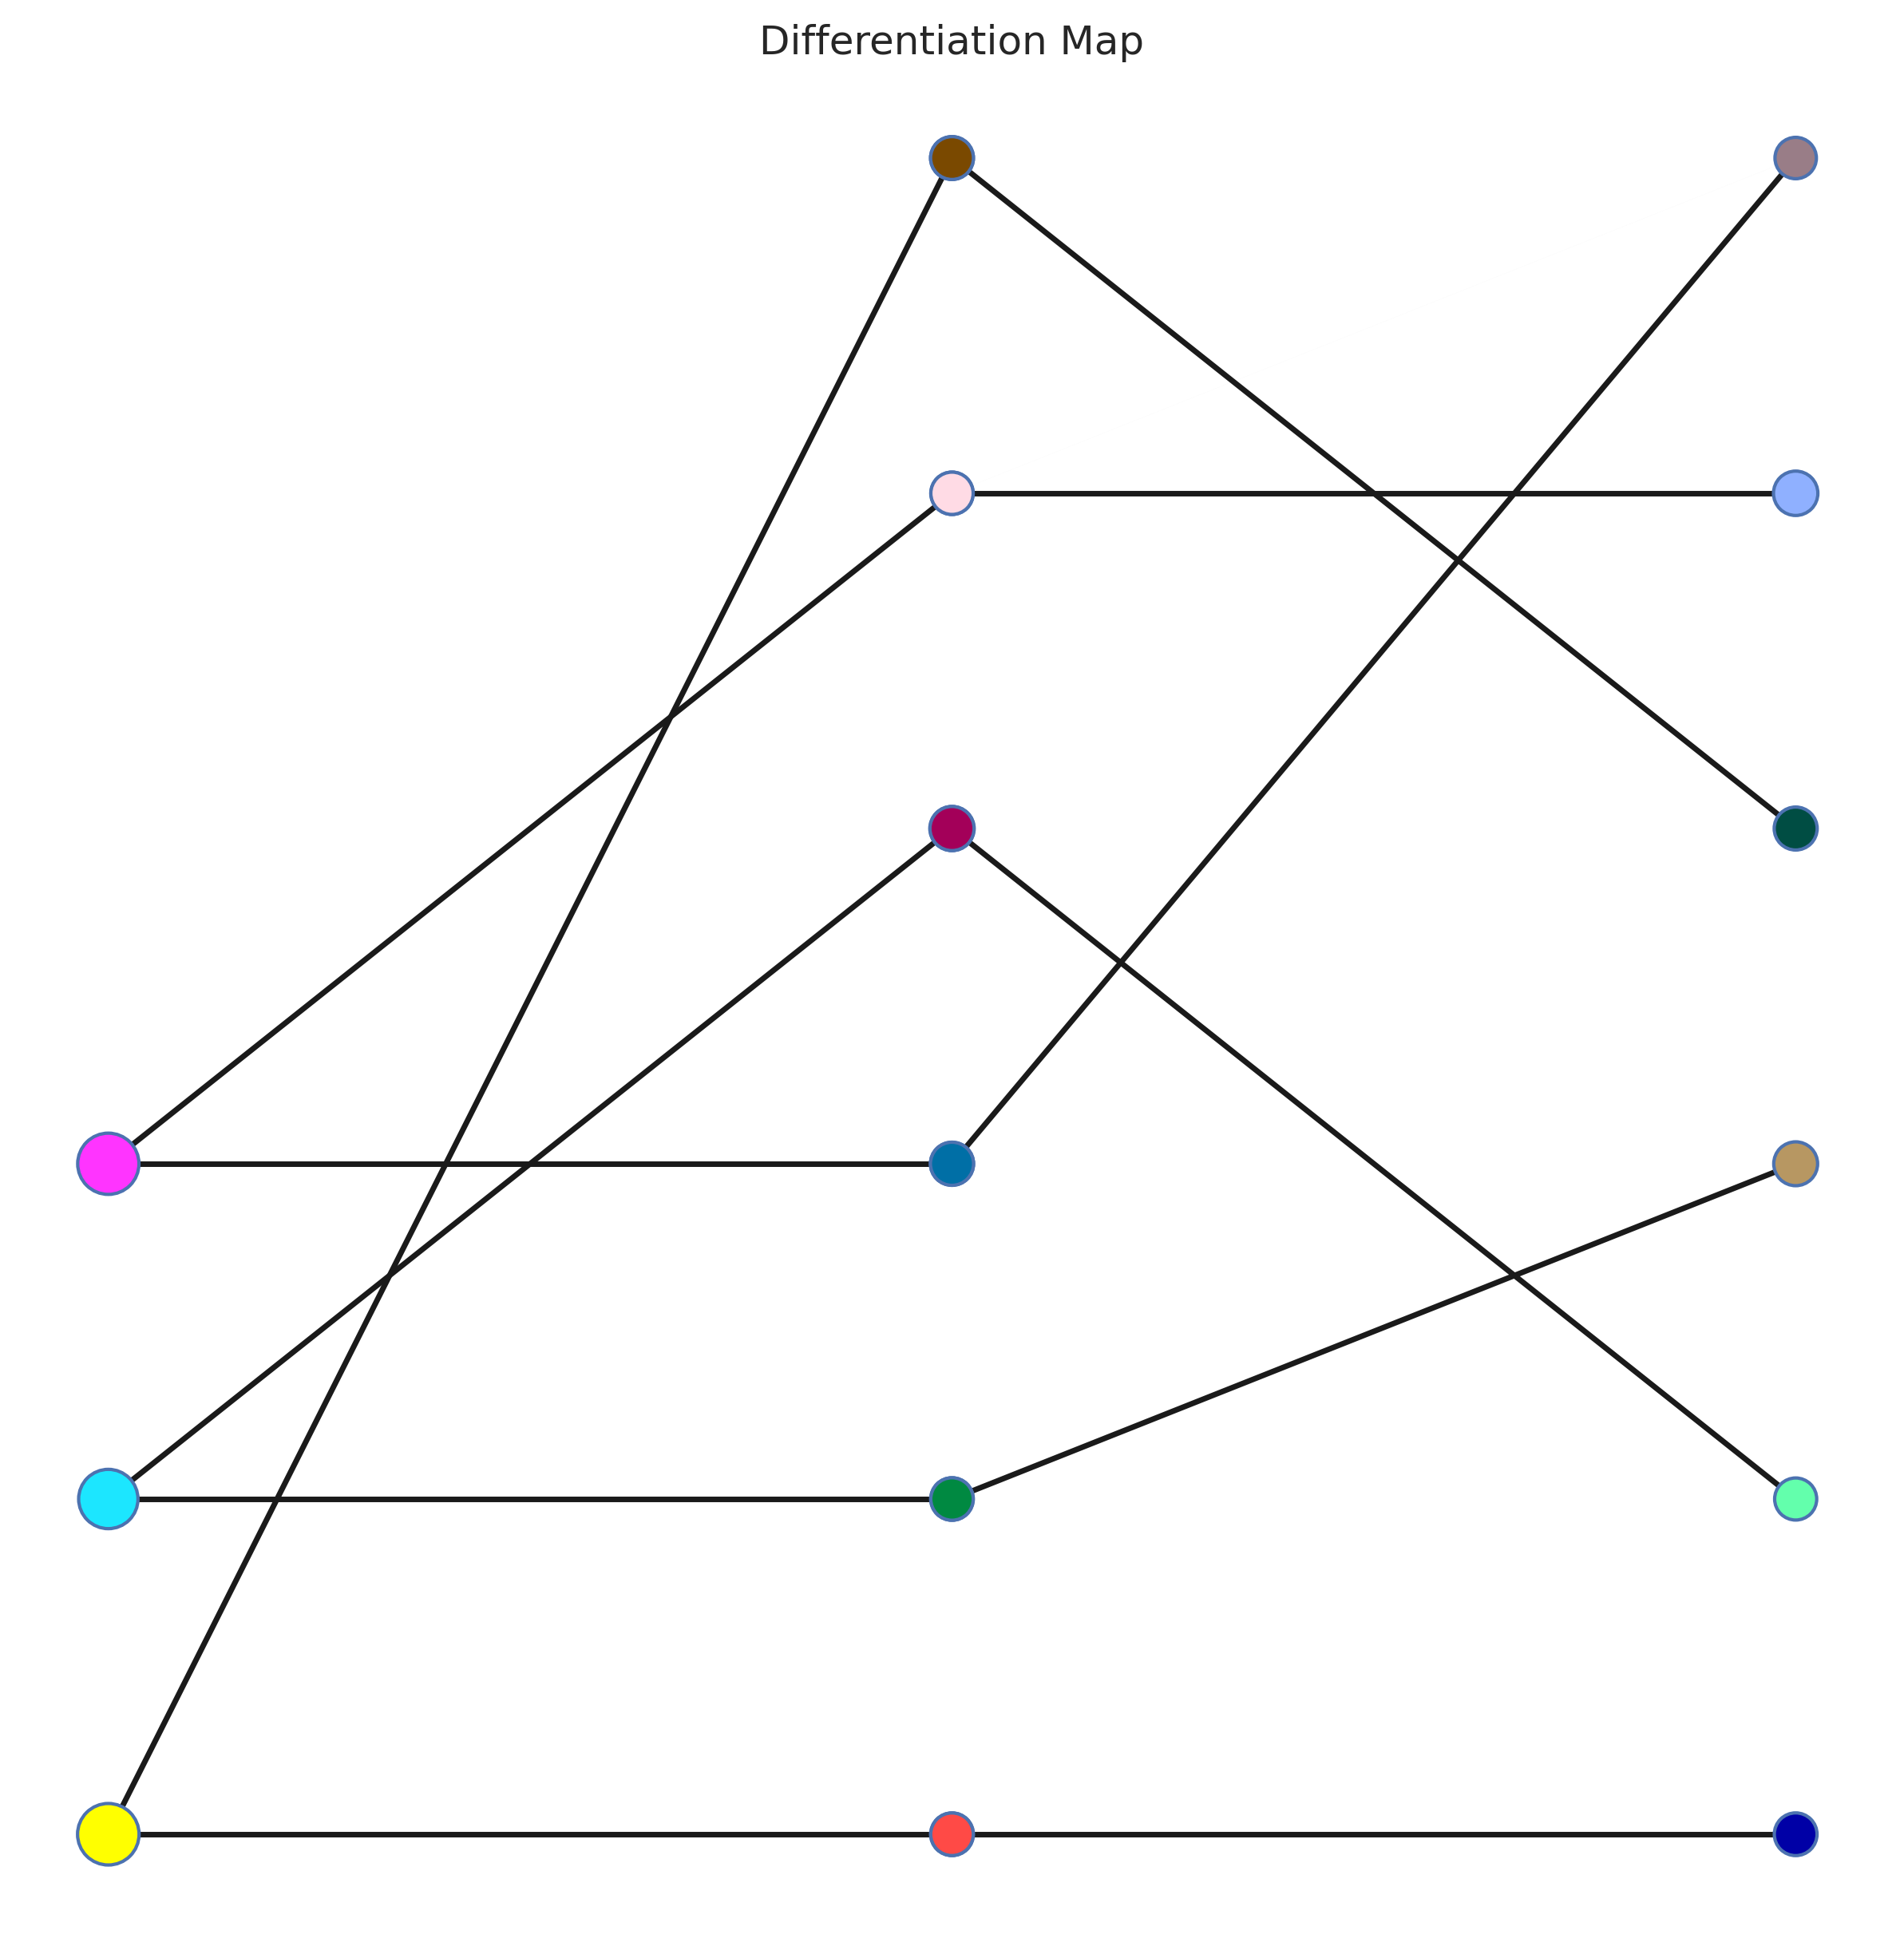

In [134]:
plotting.diffmap_from_QT(Qs_np, Ts_np)

## now run `moscot` (W-OT)

In [136]:
from anndata import AnnData

def setup_point_clouds_for_waddington_ot(point_cloud_1,
                                         point_cloud_2,
                                         time_1=0,
                                         time_2=1,
                                         ct_labels_1=None,
                                         ct_labels_2=None):
    X_combined = np.vstack([point_cloud_1, point_cloud_2])

    time_labels = np.concatenate([
        np.full(point_cloud_1.shape[0], time_1),
        np.full(point_cloud_2.shape[0], time_2)
    ])

    cell_ids = np.arange(X_combined.shape[0])

    adata = AnnData(X=X_combined)
    adata.obs['time_point'] = time_labels
    adata.obs['cell_id'] = cell_ids
    adata.obs_names = [f"cell_{i}" for i in range(X_combined.shape[0])]
    adata.var_names = ['dim_1', 'dim_2']

    if ct_labels_1 is not None and ct_labels_2 is not None:
        combined_ct_labels = np.concatenate([ct_labels_1, ct_labels_2])
        adata.obs['celltype'] = combined_ct_labels

    return adata

In [137]:
adata_12 = setup_point_clouds_for_waddington_ot(X1,
                                                X2,
                                                ct_labels_1=klabels1,
                                                ct_labels_2=klabels2)
adata_12.obs["celltype"] = adata_12.obs["celltype"].astype("category")
adata_23 = setup_point_clouds_for_waddington_ot(X2,
                                                X3,
                                                ct_labels_1=klabels2,
                                                ct_labels_2=klabels3)
adata_23.obs["celltype"] = adata_23.obs["celltype"].astype("category")
tp_12 = mt.problems.time.TemporalProblem(adata_12)
tp_23 = mt.problems.time.TemporalProblem(adata_23)

tp_12.prepare(time_key='time_point')
tp_23.prepare(time_key='time_point')

solve_kwargs = {
    'epsilon': 0.05,
    'tau_a': 1.0,
    'tau_b': 1.0,
}

In [138]:
tp_12.solve(**solve_kwargs)

# Extract results
pi_12 = tp_12.solutions[(0, 1)].transport_matrix

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(999, 999)].                                    


In [139]:
tp_23.solve(**solve_kwargs)

# Extract results
pi_23 = tp_23.solutions[(0, 1)].transport_matrix

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(999, 999)].                                    


In [140]:
tp_12.cell_transition(source = 0,
                      target = 1,
                      source_groups="celltype",
                      target_groups="celltype",
                      forward=True,
                      key_added="cell_transition"
                )

tm = adata_12.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

tm_ordered = tm.loc[np.unique(klabels1), np.unique(klabels2)]
T12_ = tm_ordered.to_numpy()
Q1 = Qs_ann[0] / Qs_ann[0].sum()
T12 = np.diag(np.sum(Q1, axis=0)) @ T12_

In [141]:
T12.sum(axis=0)

array([0.3342241 , 0.09110237, 0.16721207, 0.14214561, 0.09911768,
       0.16619817])

In [142]:
tp_23.cell_transition(source = 0,
                      target = 1,
                      source_groups="celltype",
                      target_groups="celltype",
                      forward=True,
                      key_added="cell_transition"
                )

tm = adata_23.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

tm_ordered = tm.loc[np.unique(klabels2), np.unique(klabels3)]
T23_ = tm_ordered.to_numpy()
Q2 = Qs_ann[1] / Qs_ann[1].sum()
T23 = np.diag(np.sum(Q2, axis=0)) @ T23_

In [143]:
Ts_wot = [T12, T23]

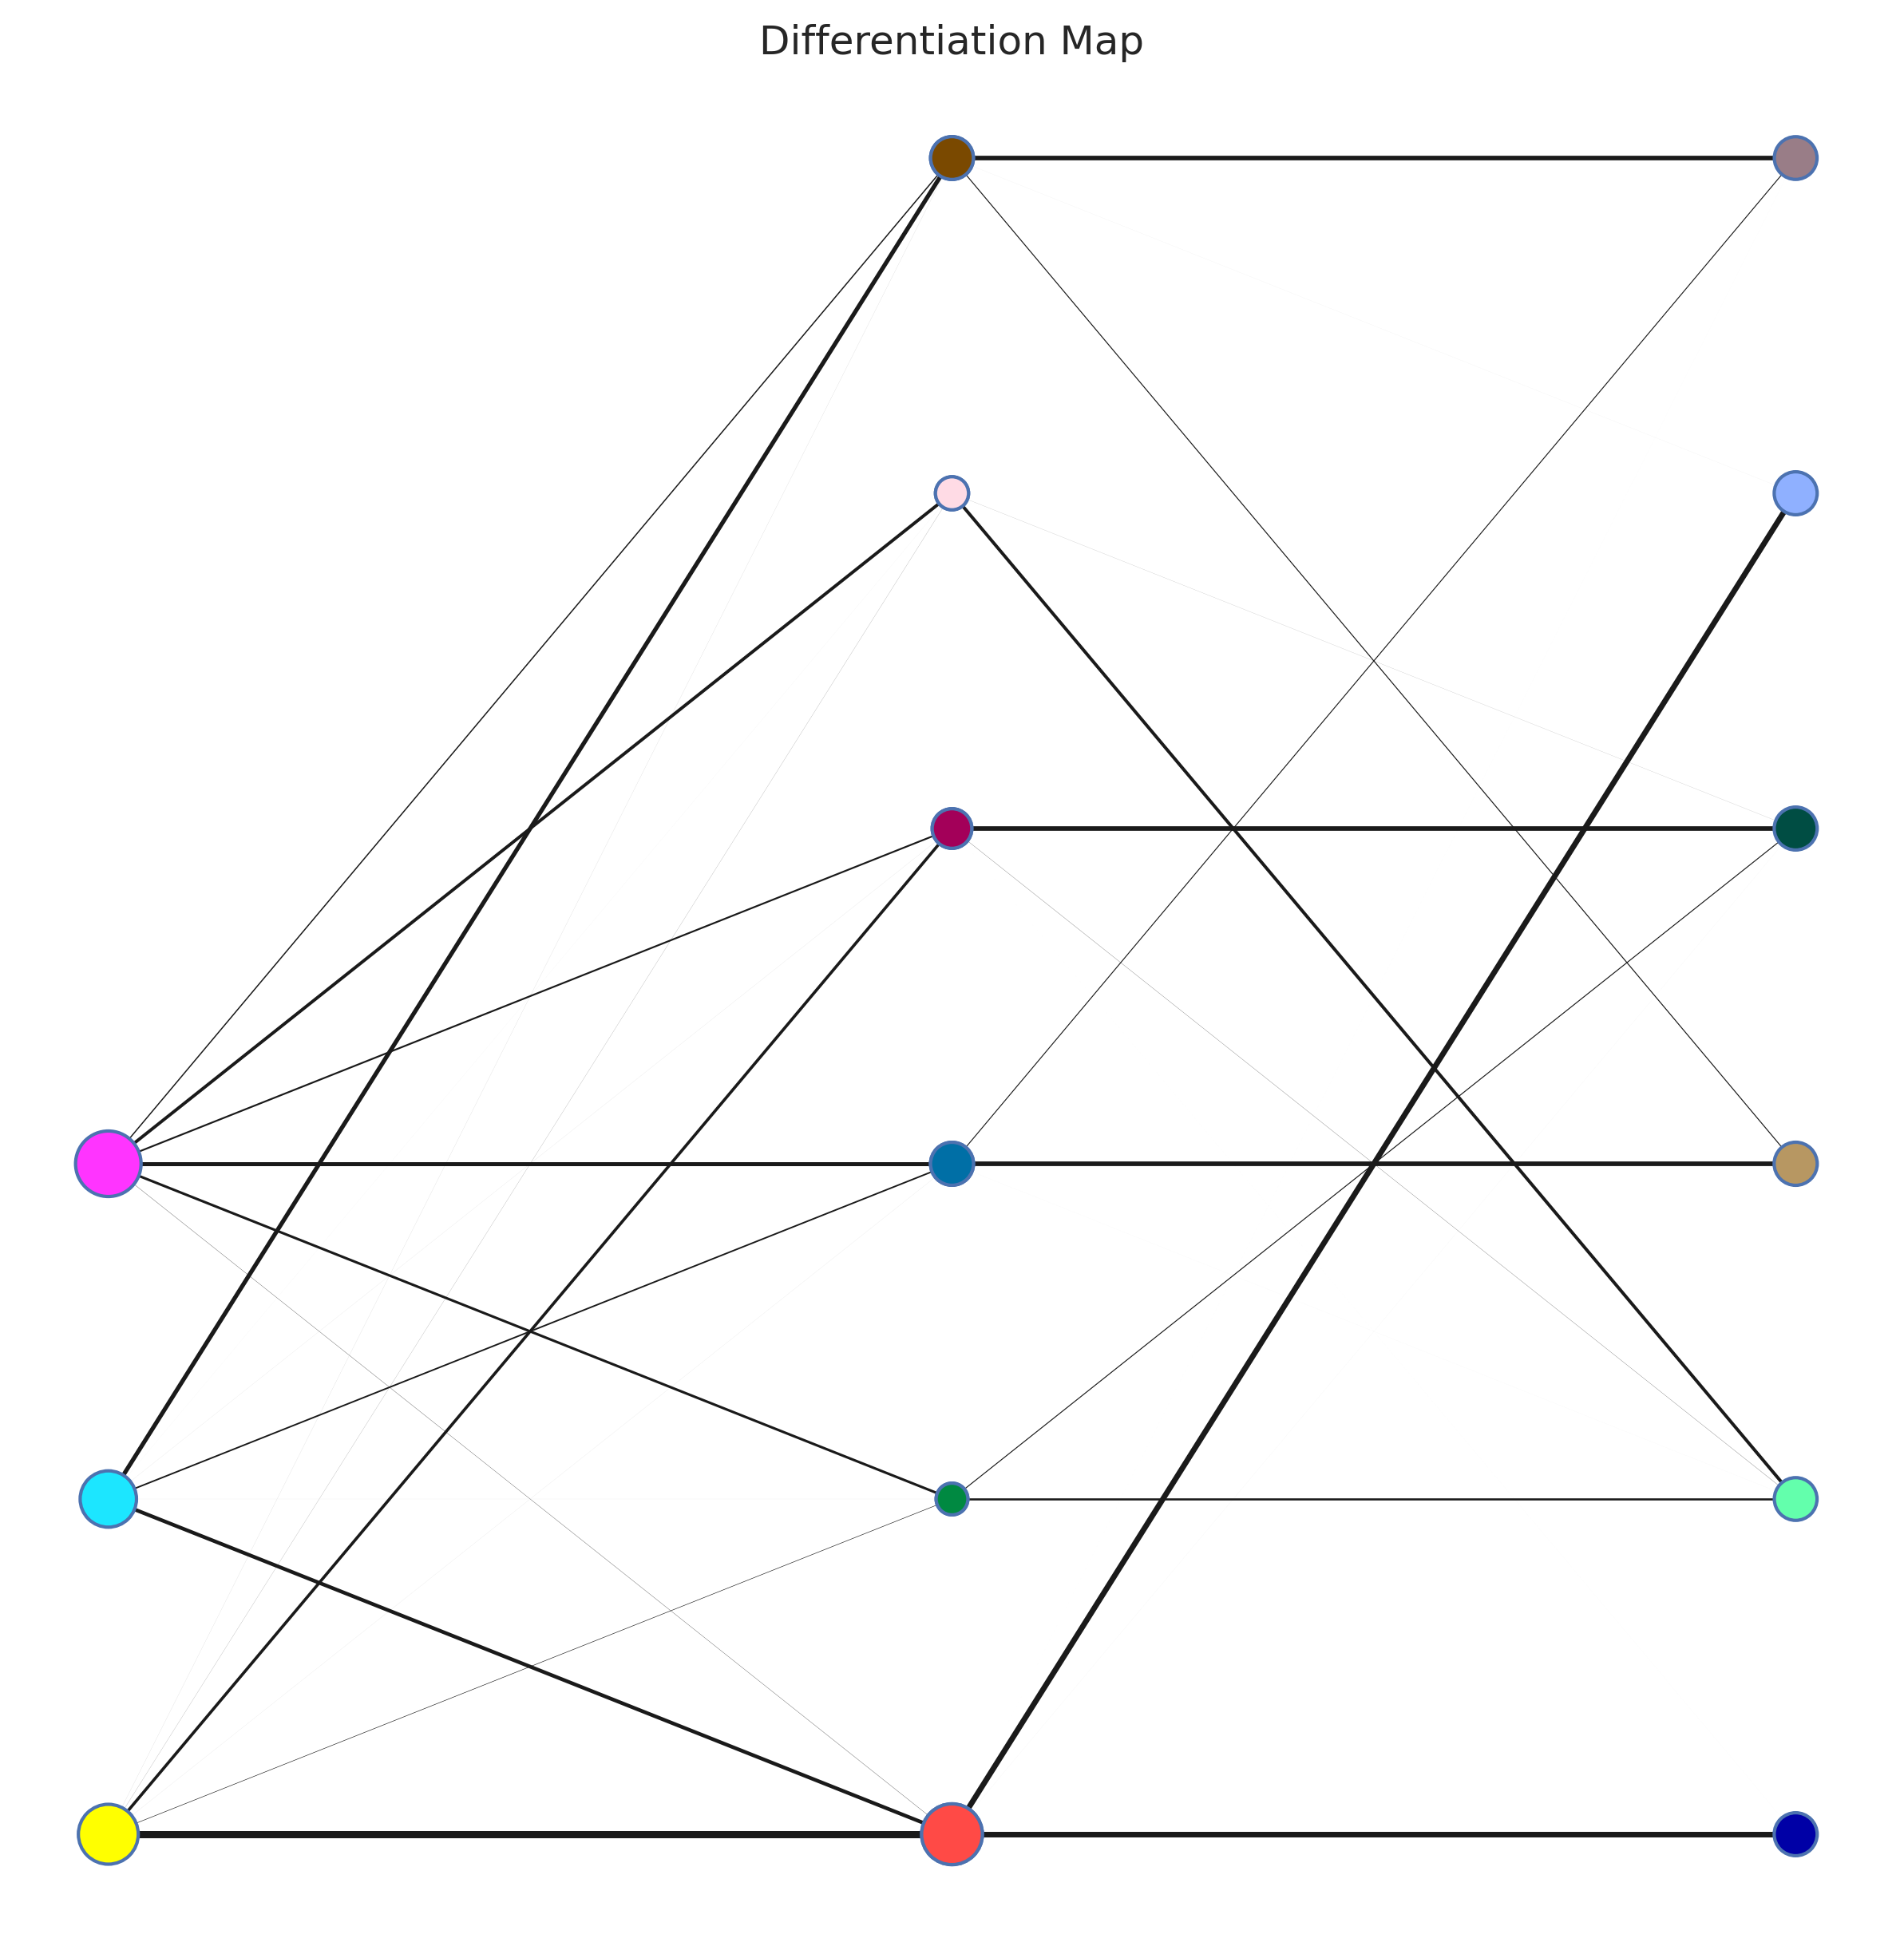

In [144]:
plotting.diffmap_from_QT(Qs_ann, Ts_wot)

In [145]:
importlib.reload(plotting)

<module 'src.plotting' from '/content/drive/Othercomputers/numac/GitHub/HM-OT/src/plotting.py'>

In [146]:
centres = {
    0: {2: np.r_[ -0.11,  0.11], # pink
        1: np.r_[ -0.11, -0.22], # cyan
        0: np.r_[  0.11,  0.00]}, # yellow

    1: {6: np.r_[ -1.0,  1.5],     # checked, maroon, pink child
        7: np.r_[ -1.5,  1.0],     # checked, lightpink, pink child
        4: np.r_[ -0.5, -2.0],     # checked, green, cyan child
        8: np.r_[ -1.0, -1.5],     # checked, brown, cyan child
        3: np.r_[  1.5,  0.5],     # checked, red, yellow child
        5: np.r_[  1.5, -0.5]},    # checked, grayblue, yellow child

    2: {13: np.r_[ -1.5,  2.0],    # checked, lightblue, maroon child
        14: np.r_[ -2.5,  1.0],    # checked, lightbrown, lightpink child
        10: np.r_[ -0.5, -2.5],    #
        11: np.r_[ -2.0, -1.5],    #
        12: np.r_[  2.0,  1.0],    # checked, darkblue, grayblue child
        9: np.r_[  2.0, -1.0]},   # checked, darkgreen, red child
}

fig, ax = plotting.plot_diffmap_clusters_prime(
    X,                   # your (N×2) point‐cloud
    time_labels,         # length-N array of 0,1,2…
    Qs_np,               # list of factor matrices Qs_np[t]: (n_t × k_t)
    Ts_np,               # list of transition matrices Ts_np[t]: (k_t × k_{t+1})
    df,                  # your DataFrame with “x”,”y”,”timepoint” columns
)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [147]:
fig, ax = plotting.plot_diffmap_clusters_prime(
    X,                   # your (N×2) point‐cloud
    time_labels,         # length-N array of 0,1,2…
    Qs_ann,               # list of factor matrices Qs_np[t]: (n_t × k_t)
    Ts_wot,               # list of transition matrices Ts_np[t]: (k_t × k_{t+1})
    df,                  # your DataFrame with “x”,”y”,”timepoint” columns
)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## compute metrics

In [108]:
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import torch

def compute_clustering_metrics(true_Q_matrices,
                               pred_Q_matrices,
                               verbose=True):
    assert len(true_Q_matrices) == len(pred_Q_matrices), \
        "Number of timepoints must match between true and predicted"

    results = {
        'timepoint_ami': [],
        'timepoint_ari': [],
        'overall_ami': None,
        'overall_ari': None
    }

    all_true_labels = []
    all_pred_labels = []

    for t, (true_Q, pred_Q) in enumerate(zip(true_Q_matrices, pred_Q_matrices)):
        if torch.is_tensor(true_Q):
            true_Q = true_Q.cpu().detach().numpy()
        if torch.is_tensor(pred_Q):
            pred_Q = pred_Q.cpu().detach().numpy()

        true_labels = np.argmax(true_Q, axis=1)
        pred_labels = np.argmax(pred_Q, axis=1)

        ami_t = adjusted_mutual_info_score(true_labels, pred_labels)
        ari_t = adjusted_rand_score(true_labels, pred_labels)

        results['timepoint_ami'].append(ami_t)
        results['timepoint_ari'].append(ari_t)

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)

        if verbose:
            print(f"Timepoint {t}:")
            print(f"  AMI: {ami_t:.4f}")
            print(f"  ARI: {ari_t:.4f}")
            print(f"  N cells: {len(true_labels)}")
            print(f"  True clusters: {len(np.unique(true_labels))}")
            print(f"  Pred clusters: {len(np.unique(pred_labels))}")
            print()
    return results

In [109]:
_ = compute_clustering_metrics(Qs_gt, Qs_ann) # evaluating k-means clusters

Timepoint 0:
  AMI: 0.0858
  ARI: 0.1008
  N cells: 3000
  True clusters: 3
  Pred clusters: 3

Timepoint 1:
  AMI: 0.8253
  ARI: 0.7901
  N cells: 3000
  True clusters: 6
  Pred clusters: 6

Timepoint 2:
  AMI: 0.9897
  ARI: 0.9928
  N cells: 3000
  True clusters: 6
  Pred clusters: 6



In [110]:
_ = compute_clustering_metrics(Qs_gt, Qs_np) # evaluating HM-OT clusters

Timepoint 0:
  AMI: 0.0861
  ARI: 0.1010
  N cells: 3000
  True clusters: 3
  Pred clusters: 3

Timepoint 1:
  AMI: 0.7317
  ARI: 0.6761
  N cells: 3000
  True clusters: 6
  Pred clusters: 6

Timepoint 2:
  AMI: 0.9596
  ARI: 0.9565
  N cells: 3000
  True clusters: 6
  Pred clusters: 6



In [151]:
labels1_gt_ = np.argmax(Qs_gt[0], axis=1)
labels2_gt_ = np.argmax(Qs_gt[1], axis=1)
labels3_gt_ = np.argmax(Qs_gt[2], axis=1)

labels1_gt = labels1_gt_
labels2_gt = labels2_gt_ + len(set(labels1_gt))
labels3_gt = labels3_gt_ + len(set(labels1_gt)) + len(set(labels2_gt))

gt_clustering_list = [labels1_gt, labels2_gt, labels3_gt]

In [152]:
plotting.plot_all_sc_clusters(spatial_list=Ss,
                              clustering_list=gt_clustering_list,
                              dotsize=100)

Output hidden; open in https://colab.research.google.com to view.